# Modelling
* The last 5 years of the data ( 4 states x 5 years = 20 data points) will be held for validation
* Cross validation requires special attention. Since this is a panel data cross validation would be more reliable if the validation data is selected based on the time index. 
    
<b style="color:red">High dimensionality problem:</b> <br>
We have 20 features 30 samples (each year) This is a problem because machine learning algorithms assumes P < n, (P: predictors, n: number of samples). Since the purpose of this study is to built an exploratry model rather than predictive model, the ultimate goal would be finding the most important features that effect crop yield. Also several parameters derived from each other. Strong colinearity surely exist among the features. The following approach may be applied to reduce the number of features and colinearity:

1. **Regularization:** Ridge, LASSO or Elastic Regressions with regularization paramaters. Would be helpful to find the most important factors affecting response variable.
2. **PCA:** PCA will help reduce the dimensions, and suitable when there is colinearity. However, we loose the interpretion ability of model. Can be used for prediction.


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
plt.style.use('ggplot')

from sklearn.linear_model import Ridge, ElasticNet, Lasso, LinearRegression
from sklearn.svm import LinearSVR, SVR

from xgboost import XGBClassifier, plot_importance

# Import TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

# RMSE
from sklearn.metrics import mean_squared_error
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [3]:
# reading data from Feature engineering step
df_pt_train_all = pd.read_pickle('Data/df_train_all_pt.pkl')
df_pt_test_all = pd.read_pickle('Data/df_test_all_pt.pkl')
df_pt_train = pd.read_pickle('Data/df_pt_train.pkl')
df_pt_test = pd.read_pickle('Data/df_pt_test.pkl')

### Regression using Yield Values

In [4]:
# Split the features and response columns 
X_train = df_pt_train.drop(['Yield','time', 'yield_chng'], axis=1)
X_train = pd.get_dummies(X_train, prefix="", 
                                  prefix_sep="", drop_first=True)
y_train = df_pt_train['Yield'] # keeping time for easy cross validation

X_test = df_pt_test.drop(['Yield','time', 'yield_chng'], axis=1)
X_test = pd.get_dummies(X_test, prefix="", 
                                  prefix_sep="", drop_first=True)
y_test = df_pt_test['Yield']

In [5]:
# Split the features and response columns for all variables 
X_train_all = df_pt_train_all.drop(['Yield','time', 'yield_chng'], axis=1)
X_train_all = pd.get_dummies(X_train_all, prefix="", 
                                  prefix_sep="", drop_first=True)
y_train_all = df_pt_train_all['Yield'] # keeping time for easy cross validation

X_test_all = df_pt_test_all.drop(['Yield','time', 'yield_chng'], axis=1)
X_test_all = pd.get_dummies(X_test_all, prefix="", 
                                  prefix_sep="", drop_first=True)
y_test_all = df_pt_test_all['Yield']

#### Cross validation
For cross validation, the function `panel_data_split` that is defined above could be used. However, sklearn's TimeSeriesSplit function will be handy here.  

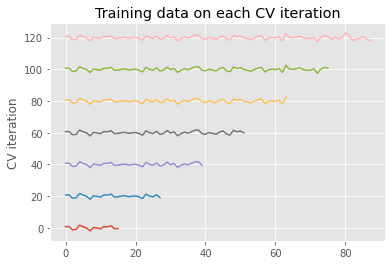

In [6]:
# For easy timesplitting let's add the time column 
# Create time-series cross-validation object
cv = TimeSeriesSplit(n_splits=7)
# Iterate through CV splits
fig, ax = plt.subplots()
for ii, (tr, tt) in enumerate(cv.split(df_pt_train.sort_values('time'))):
    # Plot the training data on each iteration, to see the behavior of the CV
    ax.plot(tr, ii*20 + y_train[tr])

ax.set(title='Training data on each CV iteration', ylabel='CV iteration')
plt.show()
plt.close()

In [7]:
def cv_score(model, df, n = 5):
    """Do cross validations for a panel data df.
    Retuns average rmse of n cross validation. 
    Note that dummy variables are created here."""
    
    # Create time-series cross-validation object
    cv = TimeSeriesSplit(n_splits=n)
    # Iterate through CV splits
    hold_score = []
    for train_index,test_index in cv.split(df):
        # split based on year 
        df_sorted = df.sort_values('time')\
            .reset_index(drop=True)
        train = df_sorted.loc[train_index]\
            .sort_values(['State', 'time']).reset_index(drop=True)
        Xtrain = train.drop(['Yield', 'time'], axis=1)
        Xtrain = pd.get_dummies(Xtrain, drop_first=True)
        ytrain = train['Yield']

        # repeating for validation data
        test = df_sorted.loc[test_index]\
            .sort_values(['State', 'time']).reset_index(drop=True)
        Xtest = test.drop(['Yield', 'time'], axis=1)
        Xtest = pd.get_dummies(Xtest, drop_first=True)
        ytest = test['Yield']
        # Fitting the model
        model.fit(Xtrain, ytrain)
        # predict for validation set 
        ypred = model.predict(Xtest)
        hold_score.append(rmse(ytest, ypred))
    return np.mean(hold_score)

In [8]:
def param_search_alpha(df,X_train,y_train, 
                       X_test,y_test, 
                       model, alphas, title, cv=5):
    scores = {'alpha':[], 'rmse':[]}
    for alpha in alphas:
        mdl = model(alpha=alpha, max_iter=5000)
        rmse_cv= cv_score(mdl, df, n=cv)
        scores['alpha'].append(alpha)
        scores['rmse'].append(rmse_cv)
    df_scores = pd.DataFrame(scores).sort_values('rmse').reset_index(drop=True)
    min_pos = df_scores['rmse'].idxmin(axis=1)
    df_scores.plot.scatter(x='alpha', y='rmse')
    plt.title(title)
    plt.savefig(f"Figures/{title.replace(' ', '')}.png")
    plt.show()
    best_alpha = df_scores.loc[min_pos]['alpha']
    print('the best alpha')
    print(best_alpha)
    
    # Let's use the best alpha and fit to entire training data
    mdl = model(alpha=best_alpha, max_iter=10000)
    mdl.fit(X_train, y_train)
    # calculate rmse for the training set
    y_pred = mdl.predict(X_train)
    train_rmse = rmse(y_train, y_pred)
    # Let's predict the test data and calculate rmse
    y_pred = mdl.predict(X_test)
    test_rmse = rmse(y_test, y_pred)
    print(f'rmse for train data: {train_rmse}')
    print(f'rmse for test data: {test_rmse}')
    
    return mdl, train_rmse, test_rmse, best_alpha

## Lasso Regression

In [9]:
model_eval = {'model':[], 'rmse_train':[], 'rmse_test':[]}

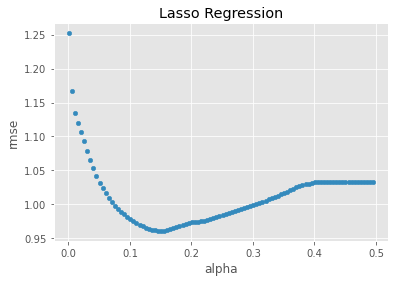

the best alpha
0.15049999999999997
rmse for train data: 0.9009888924115028
rmse for test data: 0.6128775736644193


Lasso(alpha=0.15049999999999997)

In [10]:
lasso_reg, train_rmse, test_rmse, best_alpha = param_search_alpha(df_pt_train.drop('yield_chng',axis=1),
                                                                  X_train,y_train,X_test,y_test,
                                                                  Lasso, alphas=
                                                                  np.arange(0.0005, 0.5, 0.005), 
                                                                  title='Lasso Regression', cv=3)
model_eval['model'].append('Lasso')
model_eval['rmse_train'].append(train_rmse)
model_eval['rmse_test'].append(test_rmse)
lasso_reg = Lasso(alpha=best_alpha)
lasso_reg.fit(X_train, y_train)

In [11]:
y_pred_test = lasso_reg.predict(X_test)
y_pred_train = lasso_reg.predict(X_train)
r2train = lasso_reg.score(X_train, y_train)
r2test = lasso_reg.score(X_test, y_test)
print(f'r_square_train = {r2train}')
print(f'r_square_test = {r2test}')

r_square_train = 0.18821901575109357
r_square_test = -0.18745117459878347


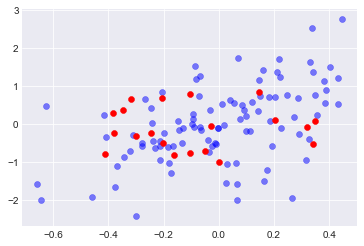

In [12]:
plt.style.use('seaborn-darkgrid')
plt.scatter(y_pred_train, y_train, c='b', alpha=0.5)
plt.scatter(y_pred_test, y_test, c='r')
plt.show()

In [13]:
coef = pd.Series(lasso_reg.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 5 variables and eliminated the other 6 variables


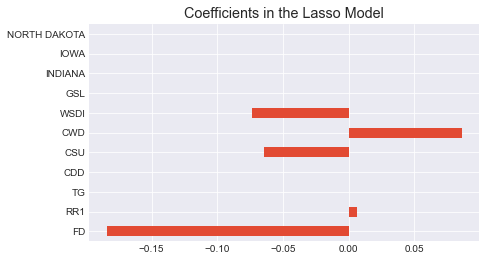

In [14]:
coef.plot(kind = "barh", figsize=(7,4))
plt.title("Coefficients in the Lasso Model")
plt.savefig('Figures/Lasso_coef.png')
plt.show()

In [15]:
# Features selected by lassso
feature_select = ['FD','RR1','CSU','WSDI']

#### Lasso regression with all available variables

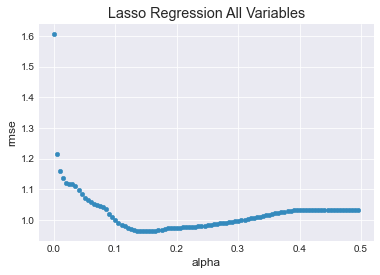

the best alpha
0.15049999999999997
rmse for train data: 0.8915955888079014
rmse for test data: 0.6072735702217242


In [16]:
lassoAll_reg, train_rmse, test_rmse, best_alpha = param_search_alpha(df_pt_train_all.drop('yield_chng',axis=1),
                                                                     X_train_all, y_train_all,X_test_all,y_test_all,
                                                                  Lasso, alphas=
                                                                  np.arange(0.0005, 0.5, 0.005), 
                                                                  title='Lasso Regression All Variables', cv=3)
model_eval['model'].append('LassoAll')
model_eval['rmse_train'].append(train_rmse)
model_eval['rmse_test'].append(test_rmse)

In [17]:
y_pred_test = lassoAll_reg.predict(X_test_all)
y_pred_train = lassoAll_reg.predict(X_train_all)
r2train = lassoAll_reg.score(X_train_all, y_train_all)
r2test = lassoAll_reg.score(X_test_all, y_test_all)
print(f'r_square_train = {r2train}')
print(f'r_square_test = {r2test}')

r_square_train = 0.20505730601829197
r_square_test = -0.1658349260042582


In [18]:
coef = pd.Series(lassoAll_reg.coef_, index = X_train_all.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 7 variables and eliminated the other 16 variables


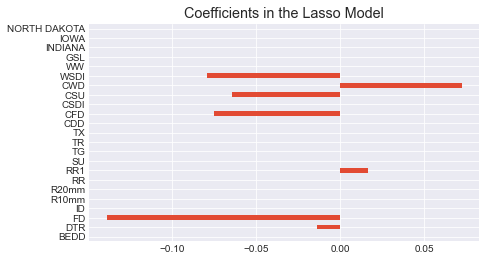

In [19]:
coef.plot(kind = "barh", figsize=(7,4))
plt.title("Coefficients in the Lasso Model")
plt.savefig('Figures/Lasso_All_coef.png')
plt.show()

<div class="span5 alert alert-warning">
    When all the variables are choosen Lasso selected two additional features. These are: <i>DTR (Mean of diurnal temperature range)</i> and <i>CFD (Maximum number of consecutive frost days)</i></div>

### Ridge Regression

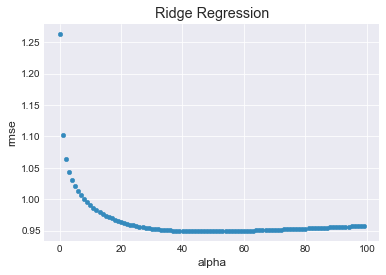

the best alpha
48.01
rmse for train data: 0.85903571735313
rmse for test data: 0.6740061834767205


In [20]:
ridge_reg, train_rmse, test_rmse, best_alpha = param_search_alpha(df_pt_train.drop('yield_chng',axis=1),
                                                                  X_train,y_train,X_test,y_test,
                                                                  Ridge, np.arange(0.01, 100, 1), cv=3,
                 title='Ridge Regression')
model_eval['model'].append('Ridge')
model_eval['rmse_train'].append(train_rmse)
model_eval['rmse_test'].append(test_rmse)

In [21]:
y_pred_test = ridge_reg.predict(X_test)
y_pred_train = ridge_reg.predict(X_train)
r2train = ridge_reg.score(X_train, y_train)
r2test = ridge_reg.score(X_test, y_test)
print(f'r_square_train = {r2train}')
print(f'r_square_test = {r2test}')

r_square_train = 0.2620576363115936
r_square_test = -0.4361376343844836


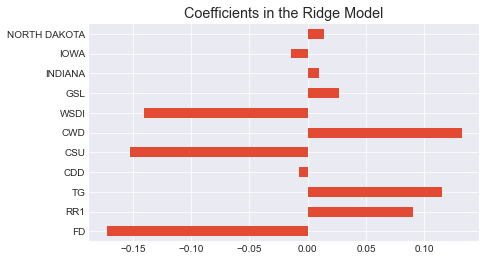

In [22]:
coef = pd.Series(ridge_reg.coef_, index = X_train.columns)
coef.plot(kind = "barh", figsize=(7,4))
plt.title("Coefficients in the Ridge Model")
plt.show()

### ElasticNet Regression

In [23]:
def param_search_alpha_l1(df, alphas, l1ratio, cv=5):
    """Grid Search parametrization for ElasticNet Regression"""
    scores = {'alpha':[], 'l1_ratio':[], 'rmse':[]}
    for alpha in alphas:
        for l1 in l1ratio:
            mdl = ElasticNet(alpha=alpha, l1_ratio=l1, max_iter=5000)
            rmse_cv= cv_score(mdl, df, n=cv)
            scores['alpha'].append(alpha)
            scores['l1_ratio'].append(l1)
            scores['rmse'].append(rmse_cv)
    df_scores = pd.DataFrame(scores).sort_values('rmse').reset_index(drop=True)
    min_pos = df_scores['rmse'].idxmin(axis=1)
    best_alpha = df_scores.loc[min_pos]['alpha']
    best_l1 = df_scores.loc[min_pos]['l1_ratio']
    print(f'the best alpha: {best_alpha}')
    print(f'Optimum l1_ratio: {best_l1}')
    
    # Let's use the best alpha and l1_ratio to fit the entire training data
    mdl = ElasticNet(alpha=best_alpha, l1_ratio=best_l1)
    mdl.fit(X_train, y_train)
    # calculate rmse for the training set
    y_pred = mdl.predict(X_train)
    train_rmse = rmse(y_train, y_pred)
    # Let's predict the test data and calculate rmse
    y_pred = mdl.predict(X_test)
    test_rmse = rmse(y_test, y_pred)
    print(f'rmse for train data: {train_rmse}')
    print(f'rmse for test data: {test_rmse}')
    
    train_score = mdl.score(X_train,y_train)
    test_score = mdl.score(X_test, y_test)
    print(f'R^2 for train: {train_score}')
    print(f'R^2 for test: {test_score}')
    
    return mdl,df_scores, train_rmse, test_rmse, best_alpha

In [24]:
elastic_reg,df_scores, train_rmse, test_rmse, best_alpha = param_search_alpha_l1(df_pt_train.drop('yield_chng', axis=1), 
                                                                     np.arange(1, 2, 0.1), 
                                                                     [1.8e-15, 2e-15,1.9e-15], cv=3)
model_eval['model'].append('ElasticNet')
model_eval['rmse_train'].append(train_rmse)
model_eval['rmse_test'].append(test_rmse)

the best alpha: 1.2000000000000002
Optimum l1_ratio: 1.8e-15
rmse for train data: 0.884235836573764
rmse for test data: 0.6238156366327801
R^2 for train: 0.2181269853186959
R^2 for test: -0.23021442390503033


### SVM

In [25]:
def param_search_crange(df, crange, cv=5):
    """Grid Search parametrization for SVM Regression"""
    scores = {'C':[], 'rmse':[]}
    for c in crange:
        mdl = LinearSVR(C=c, max_iter=5000)
        rmse_cv= cv_score(mdl, df, n=cv)
        scores['C'].append(c)
        scores['rmse'].append(rmse_cv)
    df_scores = pd.DataFrame(scores).sort_values('rmse').reset_index(drop=True)
    min_pos = df_scores['rmse'].idxmin(axis=1)
    best_c = df_scores.loc[min_pos]['C']
    print(f'optimal C: {best_c}')
    
    # Let's use the best alpha and l1_ratio to fit the entire training data
    mdl = LinearSVR(C=best_c)
    mdl.fit(X_train, y_train)
    # calculate rmse for the training set
    y_pred = mdl.predict(X_train)
    train_rmse = rmse(y_train, y_pred)
    # Let's predict the test data and calculate rmse
    y_pred = mdl.predict(X_test)
    test_rmse = rmse(y_test, y_pred)
    print(f'rmse for train data: {train_rmse}')
    print(f'rmse for test data: {test_rmse}')
    
    return mdl,df_scores, train_rmse, test_rmse

In [26]:
SVR_reg,df_scores_svm, train_rmse, test_rmse = param_search_crange(df_pt_train.drop('yield_chng', axis=1), np.arange(0.001,1.0,0.01), cv=3)
model_eval['model'].append('SVM')
model_eval['rmse_train'].append(train_rmse)
model_eval['rmse_test'].append(test_rmse)

optimal C: 0.020999999999999998
rmse for train data: 0.8699275520493404
rmse for test data: 0.7767695120338417


In [27]:
y_pred_test = SVR_reg.predict(X_test)
y_pred_train = SVR_reg.predict(X_train)
r2train = SVR_reg.score(X_train, y_train)
r2test = SVR_reg.score(X_test, y_test)
print(f'r_square_train = {r2train}')
print(f'r_square_test = {r2test}')

r_square_train = 0.24322605418544252
r_square_test = -0.9074477224317032


## XGboost

In [28]:
import xgboost as xgb

#### Fitting with the variables I selected

In [29]:
X_train.columns

Index(['FD', 'RR1', 'TG', 'CDD', 'CSU', 'CWD', 'WSDI', 'GSL', 'INDIANA',
       'IOWA', 'NORTH DAKOTA'],
      dtype='object')

In [30]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [31]:
y_pred_test = xgb_reg.predict(X_test)
y_pred_train = xgb_reg.predict(X_train)
r2train = xgb_reg.score(X_train, y_train)
r2test = xgb_reg.score(X_test, y_test)
print(f'r_square_train = {r2train}')
print(f'r_square_test = {r2test}')

r_square_train = 0.9999994369309972
r_square_test = -0.7856240901523712


In [32]:
learning_rt = np.arange(0.01, 1 ,0.01)
for l_rt in learning_rt:
    xgb_reg = xgb.XGBRegressor(learning_rate=l_rt)
    xgb_reg.fit(X_train,y_train)
    score_train = xgb_reg.score(X_train, y_train)
    score_test = xgb_reg.score(X_test, y_test)
    if score_test >= 0:
        print("Learning rate: ", l_rt)
        print("R_square (training): {0:.3f}".format(score_train))
        print("R_square (validation): {0:.3f}".format(score_test))
        print()

parametrizing Learning rate did not help improve the model. Let's try modelling with even less features.

#### Fitting with the variables Lasso Selected

In [33]:
# feature_select1 = ['FD','RR1','CSU','WSDI','INDIANA','IOWA', 'NORTH DAKOTA']

In [34]:
Xtrain = X_train[feature_select]
Xtest = X_test[feature_select]

In [35]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(Xtrain, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [36]:
y_pred_test = xgb_reg.predict(Xtest)
y_pred_train = xgb_reg.predict(Xtrain)
r2train = xgb_reg.score(Xtrain, y_train)
r2test = xgb_reg.score(Xtest, y_test)
print(f'r_square_train = {r2train}')
print(f'r_square_test = {r2test}')

r_square_train = 0.9999987885495796
r_square_test = -0.5385801276210063


##### Regularization for XGBoost

In [37]:
pd.concat([Xtrain,y_train], axis=1).corr()

,FD,RR1,CSU,WSDI,Yield
FD,1.000000,-0.062625,0.071810,0.024628,-0.348858
RR1,-0.062625,1.000000,-0.188612,-0.426473,0.254830
CSU,0.071810,-0.188612,1.000000,0.314518,-0.263993
WSDI,0.024628,-0.426473,0.314518,1.000000,-0.262106
Yield,-0.348858,0.254830,-0.263993,-0.262106,1.000000


In [38]:
learning_rt = np.arange(0.938, 0.939 ,0.0001)
hold_score = 0
for l_rt in learning_rt:
    xgb_reg = xgb.XGBRegressor(learning_rate=l_rt)
    xgb_reg.fit(Xtrain,y_train)
    score_train = xgb_reg.score(Xtrain, y_train)
    score_test = xgb_reg.score(Xtest, y_test)
    
    if score_test > hold_score-0.001:
        hold_score = score_test
        print("Learning rate: ", l_rt)
        print("R_square (training): {0:.3f}".format(score_train))
        print("R_square (validation): {0:.3f}".format(score_test))
        print()

Learning rate:  0.938
R_square (training): 1.000
R_square (validation): 0.226

Learning rate:  0.9380999999999999
R_square (training): 1.000
R_square (validation): 0.228

Learning rate:  0.9381999999999999
R_square (training): 1.000
R_square (validation): 0.230

Learning rate:  0.9382999999999999
R_square (training): 1.000
R_square (validation): 0.231

Learning rate:  0.9383999999999999
R_square (training): 1.000
R_square (validation): 0.276

Learning rate:  0.9384999999999999
R_square (training): 1.000
R_square (validation): 0.302



In [39]:
maxdepth = [2, 3, 4, 5, 6,7,8]
for md in maxdepth:
    xgb_reg = xgb.XGBRegressor(learning_rate=0.9385, max_depth=md)
    xgb_reg.fit(Xtrain,y_train)
    score_train = xgb_reg.score(Xtrain, y_train)
    score_test = xgb_reg.score(Xtest, y_test)
    if score_test >= hold_score-0.001:
        hold_score = score_test
        print("max_depth: ", md)
        print("R_square (training): {0:.3f}".format(score_train))
        print("R_square (validation): {0:.3f}".format(score_test))
        print()

max_depth:  6
R_square (training): 1.000
R_square (validation): 0.302



In [40]:
NumEst = [5,10,20,50, 100,150, 200, 250,300]
for ne in NumEst:
    xgb_reg = xgb.XGBRegressor(learning_rate=0.9385, max_depth=6,
                              n_estimators=ne)
    xgb_reg.fit(Xtrain,y_train)
    score_train = xgb_reg.score(Xtrain, y_train)
    score_test = xgb_reg.score(Xtest, y_test)
    if score_test >= hold_score-0.001:
        hold_score = score_test
        print("number of estimators: ", ne)
        print("R_square (training): {0:.3f}".format(score_train))
        print("R_square (validation): {0:.3f}".format(score_test))
        print()

number of estimators:  10
R_square (training): 1.000
R_square (validation): 0.303



In [41]:
MinChildWeight = [1,2, 3,4,5, 6,7, 8]
for mcw in MinChildWeight:
    xgb_reg = xgb.XGBRegressor(learning_rate=0.9385, max_depth=6,
                              n_estimators=10, min_child_weight=mcw)
    xgb_reg.fit(Xtrain,y_train)
    score_train = xgb_reg.score(Xtrain, y_train)
    score_test = xgb_reg.score(Xtest, y_test)
    if score_test >= hold_score-0.001:
        hold_score = score_test
        print("MinChildWeight ", mcw)
        print("R_square (training): {0:.3f}".format(score_train))
        print("R_square (validation): {0:.3f}".format(score_test))
        print()

MinChildWeight  1
R_square (training): 1.000
R_square (validation): 0.303



In [42]:
reg_alpha = [0,1e-5, 1e-2, 0.1, 0.5]
for alpha in reg_alpha:
    xgb_reg = xgb.XGBRegressor(learning_rate=0.9385, max_depth=6,
                              n_estimators=10, min_child_weight=1,
                              reg_alpha=alpha)
    xgb_reg.fit(Xtrain,y_train)
    score_train = xgb_reg.score(Xtrain, y_train)
    score_test = xgb_reg.score(Xtest, y_test)
    if score_test >= hold_score-0.001:
        hold_score = score_test
        print("reg_alpha ", alpha)
        print("R_square (training): {0:.3f}".format(score_train))
        print("R_square (validation): {0:.3f}".format(score_test))
        print()

reg_alpha  0
R_square (training): 1.000
R_square (validation): 0.303



In [43]:
xgb_reg = xgb.XGBRegressor(learning_rate=0.9385, max_depth=6,
                          n_estimators=10, min_child_weight=1,
                          reg_alpha=0)
xgb_reg.fit(Xtrain,y_train)
ypred_train = xgb_reg.predict(Xtrain)
train_rmse = rmse(ypred_train, y_train)

ypred_test = xgb_reg.predict(Xtest)
test_rmse = rmse(y_test, ypred_test)

score_train = xgb_reg.score(Xtrain, y_train)
score_test = xgb_reg.score(Xtest, y_test)

# model_eval['model'].append('XGBoost')
# model_eval['rmse_train'].append(train_rmse)
# model_eval['rmse_test'].append(test_rmse)
score_train, score_test

(0.9998353746262628, 0.30267448888330817)

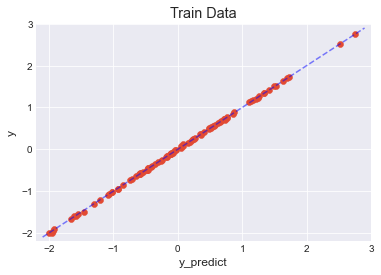

In [44]:
plt.scatter(ypred_train, y_train)
plt.title('Train Data')
plt.xlabel('y_predict')
plt.ylabel('y')
plt.ylim(-2.2,3)
plt.xlim(-2.2,3)
x=np.linspace(-2.1,2.9)
y=np.linspace(-2.1,2.9)
plt.plot(x,y,'b--', alpha=0.5)
plt.savefig('Figures/xgbreg_train_y.png')
plt.show()

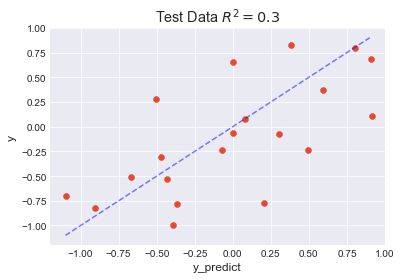

In [45]:
plt.scatter(ypred_test, y_test)
plt.title('Test Data $R^2 = 0.3$')
plt.xlabel('y_predict')
plt.ylabel('y')
plt.ylim(-1.2,1)
plt.xlim(-1.2,1)
x=np.linspace(-1.1,0.9)
y=np.linspace(-1.1,0.9)
plt.plot(x,y,'b--', alpha=0.5)
plt.savefig('Figures/xgbreg_test_y.png')
plt.show()

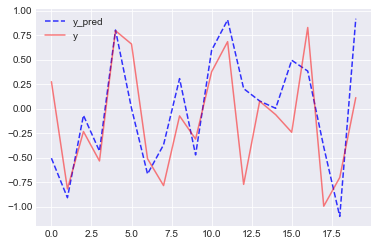

In [46]:
plt.plot(ypred_test,'b--', alpha=0.8,  label='y_pred')
plt.plot(y_test,'r-', alpha=0.5, label='y')
plt.legend()
plt.savefig('Figures/xgbreg_test_and_true_y.png')
plt.show()

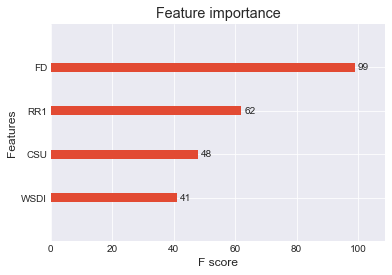

In [47]:
plot_importance(xgb_reg)
plt.savefig('Figures/xgb_reg_importance.png')
plt.show()

By far the XGBoost regression afer parametrization is the best model.

## Model Comparison

In [48]:
model_eval = pd.DataFrame(model_eval)
model_eval.set_index('model').sort_values('rmse_test').T

model,LassoAll,Lasso,ElasticNet,Ridge,SVM
rmse_train,0.891596,0.900989,0.884236,0.859036,0.869928
rmse_test,0.607274,0.612878,0.623816,0.674006,0.776770


In [104]:
model_eval = pd.DataFrame(model_eval)
model_eval.set_index('model').sort_values('rmse_test')

,rmse_train,rmse_test
model,,
XGBoost,0.000661,0.483104
LassoAll,0.891596,0.607274
Lasso,0.900989,0.612878
ElasticNet,0.884236,0.623816
Ridge,0.859036,0.674006
SVM,0.869863,0.776644


In [107]:
xgb_reg.feature_importances_

array([0.28772226, 0.1918474 , 0.2298372 , 0.29059315], dtype=float32)

## Classification

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [67]:
# Panel data Parametrization grid search for classification
model_eval = {'model':[], 'rmse_train':[], 'rmse_test':[]}
def param_search_clf(df,X_train,y_train, 
                       X_test,y_test, 
                       model, alphas, title, cv=5):
    scores = {'alpha':[], 'rmse':[]}
    for alpha in alphas:
        mdl = model(alpha=alpha, max_iter=5000)
        rmse_cv= cv_score(mdl, df, n=cv)
        scores['alpha'].append(alpha)
        scores['rmse'].append(rmse_cv)
    df_scores = pd.DataFrame(scores).sort_values('rmse').reset_index(drop=True)
    min_pos = df_scores['rmse'].idxmin(axis=1)
    df_scores.plot.scatter(x='alpha', y='rmse')
    plt.title(title)
    plt.show()
    best_alpha = df_scores.loc[min_pos]['alpha']
    print('the best alpha')
    print(best_alpha)
    
    # Let's use the best alpha and fit to entire training data
    mdl = model(alpha=best_alpha, max_iter=10000)
    mdl.fit(X_train, y_train)
    # calculate rmse for the training set
    y_pred = mdl.predict(X_train)
    train_rmse = rmse(y_train, y_pred)
    # Let's predict the test data and calculate rmse
    y_pred = mdl.predict(X_test)
    test_rmse = rmse(y_test, y_pred)
    print(f'rmse for train data: {train_rmse}')
    print(f'rmse for test data: {test_rmse}')
    
    return mdl, train_rmse, test_rmse, best_alpha

For classification models let's redefine y columns

In [68]:
y_train = df_pt_train['yield_chng']
y_train_all = df_pt_train_all['yield_chng']
y_test = df_pt_test['yield_chng']
y_test_all = df_pt_test_all['yield_chng']

### Logistic Regression

In [69]:
clf = LogisticRegression()
# Fit the model on the trainng data.
clf.fit(X_train, y_train)
# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(X_train), y_train))

0.74


In [70]:
print(accuracy_score(clf.predict(X_test), y_test))

0.4


### XGboost Classifier

In [137]:
xgb_classifier = XGBClassifier(objective = 'binary:logistic', eval_metric='logloss',
                              use_label_encoder=False, seed=27)

In [138]:
xgb_classifier.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=27, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=27, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [139]:
y_pred = xgb_classifier.predict(X_train)
score = accuracy_score(y_train, y_pred)
print(f"The accuracy of the model is {round(score,3)} based on training set.")

The accuracy of the model is 1.0 based on training set.


In [140]:
y_pred = xgb_classifier.predict(X_test)
# score model
score = accuracy_score(y_test, y_pred)
# print accuracy
print(f"The accuracy of the model based on test set. is {round(score,3)}")

The accuracy of the model based on test set. is 0.45


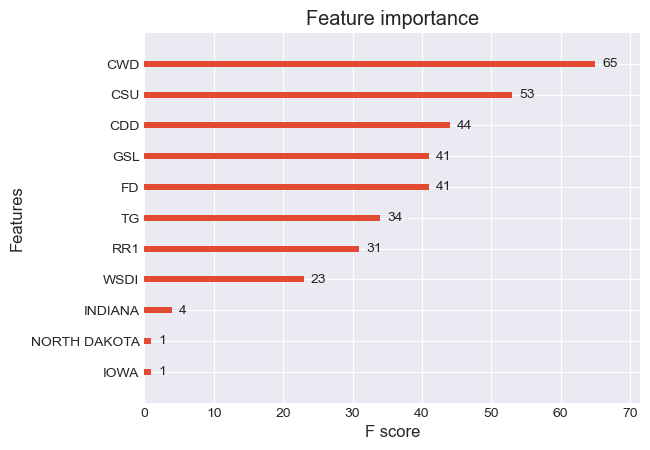

In [141]:
plot_importance(xgb_classifier)
plt.show()

#### XGB classifier for variables selected by lasso

In [151]:
xgb_classifier.fit(X_train[feature_select],y_train_all)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=27, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=27, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [152]:
y_pred = xgb_classifier.predict(X_train[feature_select])
score = accuracy_score(y_train_all, y_pred)
print(f"The accuracy of the model is {round(score,3)} based on training set.")
y_pred = xgb_classifier.predict(X_test_all[feature_select])
# score model
score = accuracy_score(y_test_all, y_pred)
# print accuracy
print(f"The accuracy of the model based on test set. is {round(score,3)}")

The accuracy of the model is 1.0 based on training set.
The accuracy of the model based on test set. is 0.5


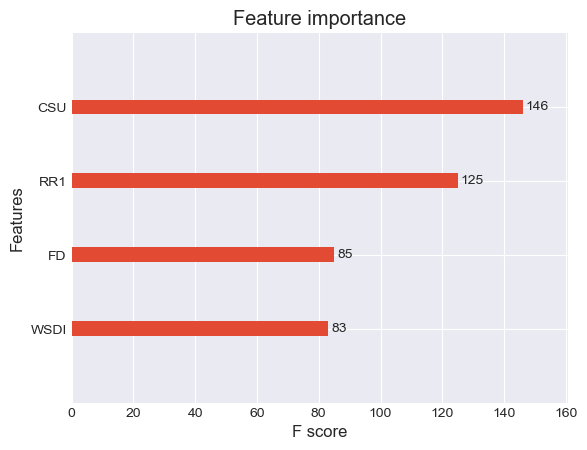

In [153]:
plot_importance(xgb_classifier)
plt.show()

#### Regularization for XGB classifier

Let's first determine the optimum n_estimator. For this we will use a relativel high learning rate

#### Learning rate

In [166]:
learning_rates = np.arange(0.7,1,0.001)
for learning_rate in learning_rates:
    gb = XGBClassifier( learning_rate = learning_rate,objective = 'binary:logistic', eval_metric='logloss',
                              use_label_encoder=False, seed=27)
    gb.fit(X_train, y_train)
    score_train = gb.score(X_train, y_train)
    score_test = gb.score(X_test, y_test)
    if score_test >= 0.7:
        print("Learning rate: ", learning_rate)
        print("Accuracy score (training): {0:.3f}".format(score_train))
        print("Accuracy score (validation): {0:.3f}".format(score_test))
        print()

Learning rate:  0.764
Accuracy score (training): 1.000
Accuracy score (validation): 0.700

Learning rate:  0.803
Accuracy score (training): 1.000
Accuracy score (validation): 0.700

Learning rate:  0.804
Accuracy score (training): 1.000
Accuracy score (validation): 0.700

Learning rate:  0.805
Accuracy score (training): 1.000
Accuracy score (validation): 0.700

Learning rate:  0.806
Accuracy score (training): 1.000
Accuracy score (validation): 0.700



#### Maximum Depth

In [184]:
MaxDepth = [2,3,4,5,6,10]
for max_depth in MaxDepth:
    gb = XGBClassifier( learning_rate = 0.805, max_depth =max_depth, objective = 'binary:logistic', eval_metric='logloss',
                              use_label_encoder=False, seed=27)
    gb.fit(X_train, y_train)
    score_train = gb.score(X_train, y_train)
    score_test = gb.score(X_test, y_test)
    if score_test >= 0.7:
        print("max_depth: ", max_depth)
        print("Accuracy score (training): {0:.3f}".format(score_train))
        print("Accuracy score (validation): {0:.3f}".format(score_test))
        print()

max_depth:  6
Accuracy score (training): 1.000
Accuracy score (validation): 0.700



#### Number of Estimator

In [186]:
NumEst = [50, 100, 200, 500, 1000]
for n_estimators in NumEst:
    gb = XGBClassifier( learning_rate = 0.805, max_depth =6,
                       n_estimators=n_estimators,
                       objective = 'binary:logistic', 
                       eval_metric='logloss',
                              use_label_encoder=False, seed=27)
    gb.fit(X_train, y_train)
    score_train = gb.score(X_train, y_train)
    score_test = gb.score(X_test, y_test)
    if score_test >= 0.7:
        print("n_estimators: ", n_estimators)
        print("Accuracy score (training): {0:.3f}".format(score_train))
        print("Accuracy score (validation): {0:.3f}".format(score_test))
        print()

n_estimators:  100
Accuracy score (training): 1.000
Accuracy score (validation): 0.700

n_estimators:  200
Accuracy score (training): 1.000
Accuracy score (validation): 0.700

n_estimators:  500
Accuracy score (training): 1.000
Accuracy score (validation): 0.700



Model has not been improving since tunning the learning rate. Still let's try some other parameterization options

#### Minimum Child Weight

In [188]:
MinChildWeight = [1, 3, 6, 8]
for min_child_weight in MinChildWeight:
    gb = XGBClassifier( learning_rate = 0.805, max_depth =6,
                       n_estimators=100,
                       min_child_weight=min_child_weight,
                       objective = 'binary:logistic', 
                       eval_metric='logloss',
                              use_label_encoder=False, seed=27)
    gb.fit(X_train, y_train)
    score_train = gb.score(X_train, y_train)
    score_test = gb.score(X_test, y_test)
    if score_test >= 0.7:
        print("min_child_weight: ", min_child_weight)
        print("Accuracy score (training): {0:.3f}".format(score_train))
        print("Accuracy score (validation): {0:.3f}".format(score_test))
        print()

min_child_weight:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.700

min_child_weight:  8
Accuracy score (training): 0.870
Accuracy score (validation): 0.700



#### Gamma

In [206]:
gammas = [i/10.0 for i in range(0,5)]
for gamma in gammas:
    gb = XGBClassifier( learning_rate = 0.805, max_depth =6,
                       n_estimators=100,
                       min_child_weight=1,
                       gamma=gamma,
                       objective = 'binary:logistic', 
                       eval_metric='logloss',
                              use_label_encoder=False, seed=27)
    gb.fit(X_train, y_train)
    score_train = gb.score(X_train, y_train)
    score_test = gb.score(X_test, y_test)
    if score_test >= 0.7:
        print("gamma: ", gamma)
        print("Accuracy score (training): {0:.3f}".format(score_train))
        print("Accuracy score (validation): {0:.3f}".format(score_test))
        print()

gamma:  0.0
Accuracy score (training): 1.000
Accuracy score (validation): 0.700



#### Tuning Regularization Parameters
reg_alpha paremeter tunning can help to reduce overfitting.

In [209]:
reg_alpha = [1e-5, 1e-2, 0.1, 1, 100]
for alpha in reg_alpha:
    gb = XGBClassifier( learning_rate = 0.805, max_depth =6,
                       n_estimators=100,
                       min_child_weight=1,
                       gamma=0,
                       reg_alpha=alpha,
                       objective = 'binary:logistic', 
                       eval_metric='logloss',
                              use_label_encoder=False, seed=27)
    gb.fit(X_train, y_train)
    score_train = gb.score(X_train, y_train)
    score_test = gb.score(X_test, y_test)
    if score_test >= 0.7:
        print("reg_alpha: ", alpha)
        print("Accuracy score (training): {0:.3f}".format(score_train))
        print("Accuracy score (validation): {0:.3f}".format(score_test))
        print()

reg_alpha:  1e-05
Accuracy score (training): 1.000
Accuracy score (validation): 0.700



In [71]:
gb = XGBClassifier( learning_rate = 0.805, max_depth =6,
                       n_estimators=100,
                       min_child_weight=1,
                       gamma=0,
                       reg_alpha=1e-05,
                       objective = 'binary:logistic', 
                       eval_metric='logloss',
                              use_label_encoder=False, seed=27)
gb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.805, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=27, reg_alpha=1e-05,
              reg_lambda=1, scale_pos_weight=1, seed=27, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

Finally let's tune the learning rate after the final values for other parameters

#### Testing the final model

In [72]:
# predict the labels
y_pred = gb.predict(X_test)
# score model
score = accuracy_score(y_test, y_pred)
# print accuracy
print(f"The accuracy of the model based on test set. is {round(score,3)}")

The accuracy of the model based on test set. is 0.7


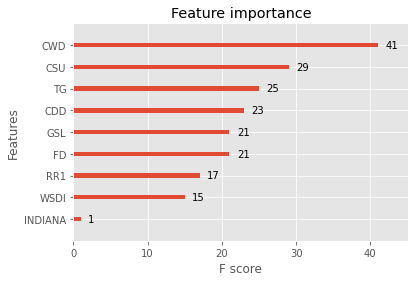

In [73]:
plot_importance(gb)
plt.show()

#### Modelling only selected features from Lasso

In [194]:
Xtrain = X_train[feature_select]
Xtest = X_test[feature_select]

In [214]:
learning_rates = np.arange(0.2,1,0.01)
for learning_rate in learning_rates:
    gb = XGBClassifier( learning_rate = learning_rate, max_depth = 2,objective = 'binary:logistic', eval_metric='logloss',
                              use_label_encoder=False, seed=27)
    gb.fit(Xtrain, y_train)
    score_train = gb.score(Xtrain, y_train)
    score_test = gb.score(Xtest, y_test)
    if score_test >= 0.7:
        print("Learning rate: ", learning_rate)
        print("Accuracy score (training): {0:.3f}".format(score_train))
        print("Accuracy score (validation): {0:.3f}".format(score_test))
        print()

Learning rate:  0.4200000000000002
Accuracy score (training): 1.000
Accuracy score (validation): 0.700

Learning rate:  0.6500000000000004
Accuracy score (training): 1.000
Accuracy score (validation): 0.700

Learning rate:  0.6600000000000004
Accuracy score (training): 1.000
Accuracy score (validation): 0.700



In [200]:
MaxDepth = [2,3,4,5,6,10]
for max_depth in MaxDepth:
    gb = XGBClassifier( learning_rate = 0.42, max_depth =max_depth, objective = 'binary:logistic', eval_metric='logloss',
                              use_label_encoder=False, seed=27)
    gb.fit(Xtrain, y_train)
    score_train = gb.score(Xtrain, y_train)
    score_test = gb.score(Xtest, y_test)
    if score_test >= 0.7:
        print("max_depth: ", max_depth)
        print("Accuracy score (training): {0:.3f}".format(score_train))
        print("Accuracy score (validation): {0:.3f}".format(score_test))
        print()

max_depth:  2
Accuracy score (training): 1.000
Accuracy score (validation): 0.700



In [202]:
NumEst = [50, 100, 200, 500, 1000]
for n_estimators in NumEst:
    gb = XGBClassifier( learning_rate = 0.42, max_depth=2,
                       n_estimators=n_estimators,
                       objective = 'binary:logistic', 
                       eval_metric='logloss',
                              use_label_encoder=False, seed=27)
    gb.fit(Xtrain, y_train)
    score_train = gb.score(Xtrain, y_train)
    score_test = gb.score(Xtest, y_test)
    if score_test >= 0.7:
        print("n_estimators: ", n_estimators)
        print("Accuracy score (training): {0:.3f}".format(score_train))
        print("Accuracy score (validation): {0:.3f}".format(score_test))
        print()

n_estimators:  100
Accuracy score (training): 1.000
Accuracy score (validation): 0.700



In [203]:
MinChildWeight = [1, 3, 6, 8]
for min_child_weight in MinChildWeight:
    gb = XGBClassifier( learning_rate = 0.42, max_depth=2,
                       n_estimators=100,
                       min_child_weight=min_child_weight,
                       objective = 'binary:logistic', 
                       eval_metric='logloss',
                              use_label_encoder=False, seed=27)
    gb.fit(Xtrain, y_train)
    score_train = gb.score(Xtrain, y_train)
    score_test = gb.score(Xtest, y_test)
    if score_test >= 0.7:
        print("min_child_weight: ", min_child_weight)
        print("Accuracy score (training): {0:.3f}".format(score_train))
        print("Accuracy score (validation): {0:.3f}".format(score_test))
        print()

min_child_weight:  1
Accuracy score (training): 1.000
Accuracy score (validation): 0.700



In [204]:
gammas = [i/10.0 for i in range(0,5)]
for gamma in gammas:
    gb = XGBClassifier( learning_rate = 0.42, max_depth=2,
                       n_estimators=100,
                       min_child_weight=1,
                       gamma=gamma,
                       objective = 'binary:logistic', 
                       eval_metric='logloss',
                              use_label_encoder=False, seed=27)
    gb.fit(Xtrain, y_train)
    score_train = gb.score(Xtrain, y_train)
    score_test = gb.score(Xtest, y_test)
    if score_test >= 0.7:
        print("gamma: ", gamma)
        print("Accuracy score (training): {0:.3f}".format(score_train))
        print("Accuracy score (validation): {0:.3f}".format(score_test))
        print()

gamma:  0.0
Accuracy score (training): 1.000
Accuracy score (validation): 0.700



In [220]:
reg_alpha = [1e-5, 1e-2, 0.1, 1, 100]
for alpha in reg_alpha:
    gb = XGBClassifier( learning_rate = 0.42, max_depth=2,
                       n_estimators=100,
                       min_child_weight=1,
                       gamma=0,
                       reg_alpha=alpha,
                       objective = 'binary:logistic', 
                       eval_metric='logloss',
                              use_label_encoder=False, seed=27)
    gb.fit(Xtrain, y_train)
    score_train = gb.score(Xtrain, y_train)
    score_test = gb.score(Xtest, y_test)
    if score_test >= 0.7:
        print("reg_alpha: ", alpha)
        print("Accuracy score (training): {0:.3f}".format(score_train))
        print("Accuracy score (validation): {0:.3f}".format(score_test))
        print()

reg_alpha:  1e-05
Accuracy score (training): 1.000
Accuracy score (validation): 0.700

reg_alpha:  0.01
Accuracy score (training): 1.000
Accuracy score (validation): 0.700



In [74]:
gb = XGBClassifier( learning_rate = 0.42, max_depth=2,
                       n_estimators=100,
                       min_child_weight=1,
                       gamma=0,
                       reg_alpha=0.01,
                       objective = 'binary:logistic', 
                       eval_metric='logloss',
                              use_label_encoder=False, seed=27)
gb.fit(Xtrain, y_train)
score_train = gb.score(Xtrain, y_train)
score_test = gb.score(Xtest, y_test)
print(f'train score: {score_train}, test score: {score_test}')

train score: 1.0, test score: 0.7


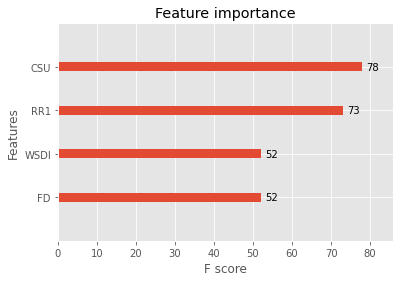

In [75]:
plot_importance(gb)
plt.savefig('Figures/xgb_clf_feat_imp.png')
plt.show()